In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# t-Distributed Stochastic Neighbor Embedding (t-SNE) in sklearn

t-SNE is a tool for data visualization. It reduces the dimensionality of data to 2 or 3 dimensions so that it can be plotted easily. Local similarities are preserved by this embedding.

t-SNE converts distances between data in the original space to probabilities. First, we compute conditional probabilites

$$p_{j|i} = \frac{\exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_j) / (2 \sigma_i^2)})}{\sum_{i \neq k} \exp{(-d(\boldsymbol{x}_i, \boldsymbol{x}_k) / (2 \sigma_i^2)})}, \quad p_{i|i} = 0,$$

which will be used to generate joint probabilities

$$p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}.$$

The $\sigma_i$ will be determined automatically. This procedure can be influenced by setting the `perplexity` of the algorithm.

A heavy-tailed distribution will be used to measure the similarities in the embedded space

$$q_{ij} = \frac{(1 + ||\boldsymbol{y}_i - \boldsymbol{y}_j)||^2)^{-1}}{\sum_{k \neq l} (1 + ||\boldsymbol{y}_k - \boldsymbol{y}_l)||^2)^{-1}},$$

and then we minimize the Kullback-Leibler divergence

$$KL(P|Q) = \sum_{i \neq j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$$

between both distributions with gradient descent (and some tricks). Note that the cost function is not convex and multiple runs might yield different results.

More information can be found in these resources and in the documentation from t-SNE:

* Website (Implementations, FAQ, etc.): [t-Distributed Stochastic Neighbor Embedding](http://homepage.tudelft.nl/19j49/t-SNE.html)
* Original paper: [Visualizing High-Dimensional Data Using t-SNE](http://jmlr.org/papers/volume9/vandermaaten08a/vandermaaten08a.pdf)

In [2]:
from sklearn.manifold import TSNE

help(TSNE)

Help on class TSNE in module sklearn.manifold.t_sne:

class TSNE(sklearn.base.BaseEstimator)
 |  t-distributed Stochastic Neighbor Embedding.
 |  
 |  t-SNE [1] is a tool to visualize high-dimensional data. It converts
 |  similarities between data points to joint probabilities and tries
 |  to minimize the Kullback-Leibler divergence between the joint
 |  probabilities of the low-dimensional embedding and the
 |  high-dimensional data. t-SNE has a cost function that is not convex,
 |  i.e. with different initializations we can get different results.
 |  
 |  It is highly recommended to use another dimensionality reduction
 |  method (e.g. PCA for dense data or TruncatedSVD for sparse data)
 |  to reduce the number of dimensions to a reasonable amount (e.g. 50)
 |  if the number of features is very high. This will suppress some
 |  noise and speed up the computation of pairwise distances between
 |  samples. For more tips see Laurens van der Maaten's FAQ [2].
 |  
 |  Read more in the 

## A simple example: the Iris dataset

In [3]:
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA

iris = load_iris()
X_tsne = TSNE(learning_rate=100).fit_transform(iris.data)
X_pca = PCA().fit_transform(iris.data)

t-SNE can help us to decide whether classes are separable in some linear or nonlinear representation. Here we can see that the 3 classes of the Iris dataset can be separated quite easily. They can even be separated linearly which we can conclude from the low-dimensional embedding of the `PCA`.

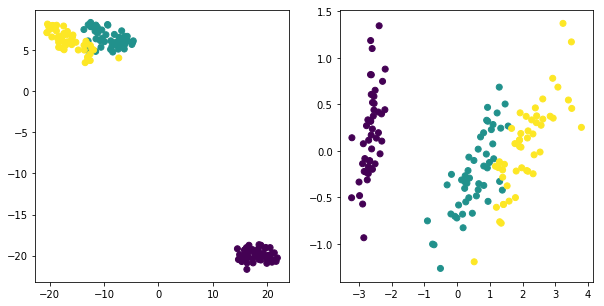

In [4]:
figure(figsize=(10, 5))
subplot(121)
scatter(X_tsne[:, 0], X_tsne[:, 1], c=iris.target)
subplot(122)
scatter(X_pca[:, 0], X_pca[:, 1], c=iris.target)

## High-dimensional sparse data: the 20 newsgroups dataset

In high-dimensional and nonlinear domains, PCA is not applicable any more and many other manifold learning algorithms do not yield good visualizations either because they try to preserve the global data structure.

In [5]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups = fetch_20newsgroups(subset="train", categories=categories)
vectors = TfidfVectorizer().fit_transform(newsgroups.data)

In [6]:
print(repr(vectors))

<2034x34118 sparse matrix of type '<class 'numpy.float64'>'
	with 323433 stored elements in Compressed Sparse Row format>


For high-dimensional sparse data it is helpful to first reduce the dimensions to 50 dimensions with `TruncatedSVD` and then perform t-SNE. This will usually improve the visualization.

In [7]:
from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(vectors)

In [8]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 2034 samples in 0.002s...
[t-SNE] Computed neighbors for 2034 samples in 0.442s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2034
[t-SNE] Computed conditional probabilities for sample 2000 / 2034
[t-SNE] Computed conditional probabilities for sample 2034 / 2034
[t-SNE] Mean sigma: 0.107856
[t-SNE] Computed conditional probabilities in 0.142s
[t-SNE] Iteration 50: error = 73.8630829, gradient norm = 0.1304796 (50 iterations in 2.827s)
[t-SNE] Iteration 100: error = 73.4907913, gradient norm = 0.1119761 (50 iterations in 2.783s)
[t-SNE] Iteration 150: error = 73.4028244, gradient norm = 0.1071175 (50 iterations in 2.439s)
[t-SNE] Iteration 200: error = 73.5089722, gradient norm = 0.1149184 (50 iterations in 2.680s)
[t-SNE] Iteration 250: error = 73.8698273, gradient norm = 0.0751583 (50 iterations in 2.296s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.869827
[t-SNE] Iteration 300: err

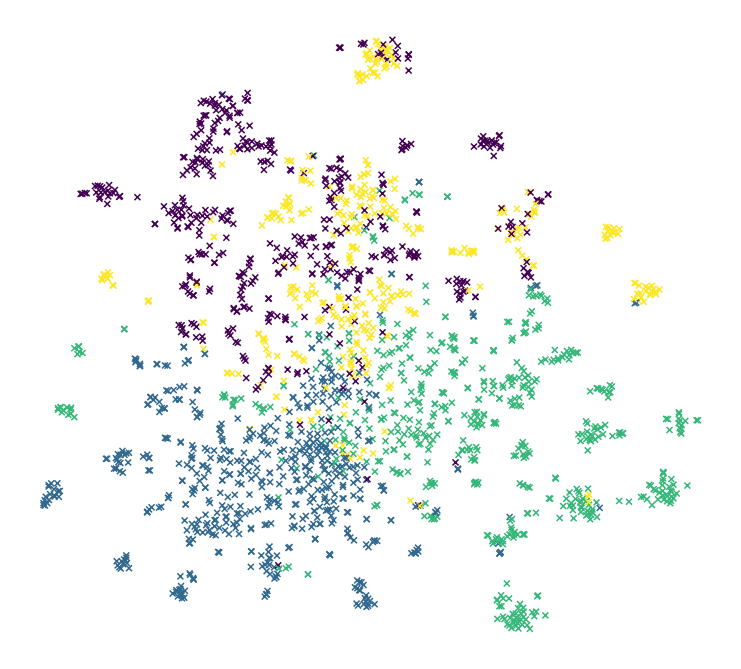

In [9]:
fig = figure(figsize=(10, 10))
ax = axes(frameon=False)
setp(ax, xticks=(), yticks=())
subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
scatter(X_embedded[:, 0], X_embedded[:, 1],
        c=newsgroups.target, marker="x")

# MNIST dataset

In [10]:
from sklearn.datasets import fetch_mldata

# Load MNIST dataset
mnist = fetch_mldata("MNIST original")
X, y = mnist.data / 255.0, mnist.target

# Create subset and reduce to first 50 dimensions
indices = arange(X.shape[0])
random.shuffle(indices)
n_train_samples = 5000
X_pca = PCA(n_components=50).fit_transform(X)
X_train = X_pca[indices[:n_train_samples]]
y_train = y[indices[:n_train_samples]]

In [11]:
# Plotting function
matplotlib.rc('font', **{'family' : 'sans-serif',
                         'weight' : 'bold',
                         'size'   : 18})
matplotlib.rc('text', **{'usetex' : True})

def plot_mnist(X, y, X_embedded, name, min_dist=10.0):
    fig = figure(figsize=(10, 10))
    ax = axes(frameon=False)
    title("\\textbf{MNIST dataset} -- Two-dimensional "
          "embedding of 70,000 handwritten digits with %s" % name)
    setp(ax, xticks=(), yticks=())
    subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                    wspace=0.0, hspace=0.0)
    scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=y, marker="x")

    if min_dist is not None:
        from matplotlib import offsetbox
        shown_images = np.array([[15., 15.]])
        indices = arange(X_embedded.shape[0])
        random.shuffle(indices)
        for i in indices[:5000]:
            dist = np.sum((X_embedded[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist:
                continue
            shown_images = np.r_[shown_images, [X_embedded[i]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(X[i].reshape(28, 28),
                                      cmap=cm.gray_r), X_embedded[i])
            ax.add_artist(imagebox)

In [12]:
X_train_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_train)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.007s...
[t-SNE] Computed neighbors for 5000 samples in 2.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.057648
[t-SNE] Computed conditional probabilities in 0.307s
[t-SNE] Iteration 50: error = 85.9097519, gradient norm = 0.0012122 (50 iterations in 5.078s)
[t-SNE] Iteration 100: error = 80.5669250, gradient norm = 0.0020733 (50 iterations in 5.030s)
[t-SNE] Iteration 150: error = 80.2819672, gradient norm = 0.0004684 (50 iterations in 4.781s)
[t-SNE] Iteration 200: error = 80.2571869, gradient norm = 0.0000918 (50 iterations in 4.750s)
[t-SNE] Iteration 250: error = 80.2549286, gradient norm = 0.000077

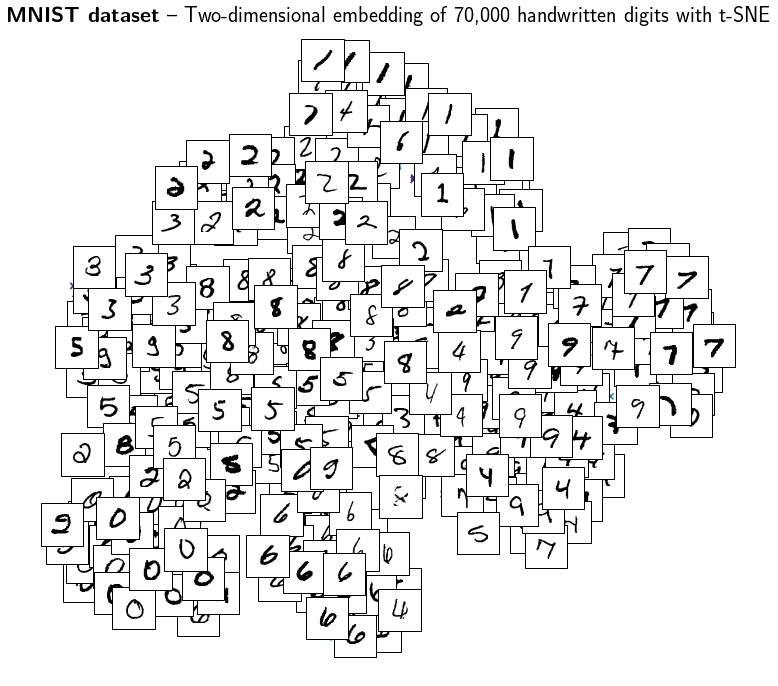

In [13]:
plot_mnist(X[indices[:n_train_samples]], y_train, X_train_embedded,
           "t-SNE", min_dist=20.0)

# Outlook

There are some modifications of t-SNE that already have been published. A huge disadvantage of t-SNE is that it scales quadratically with the number of samples ($O(N^2)$) and the optimization is quite slow. These issues and more have been adressed in the following papers:

* Parametric t-SNE: [Learning a Parametric Embedding by Preserving Local Structure](http://jmlr.csail.mit.edu/proceedings/papers/v5/maaten09a/maaten09a.pdf)
* Barnes-Hut SNE: [Barnes-Hut-SNE](http://arxiv.org/abs/1301.3342)
* Fast optimization: [Fast Optimization for t-SNE](http://cseweb.ucsd.edu/~lvdmaaten/workshops/nips2010/papers/vandermaaten.pdf)